In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import dataframe
from pyspark.sql.types import StructType, StructField, DoubleType
import xgboost as xgb
import time
import glob
import json
from matplotlib import rc

rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = []
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'light'

df_dict = {}
data = {}

In [21]:
# Spark session and configuration
spark = (SparkSession.builder.master("local[48]")
         .config('spark.executor.instances', 16)
         .config('spark.executor.cores', 16)
         .config('spark.executor.memory', '10g')
         .config('spark.driver.memory', '15g')
         .config('spark.memory.offHeap.enabled', True)
         .config('spark.memory.offHeap.size', '20g')
         .config('spark.dirver.maxResultSize', '20g')
         .config('spark.debug.maxToStringFields', 100)
         .appName("amp.hell").getOrCreate())

# Enable Arrow-based columnar data 
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set(
    "spark.sql.execution.arrow.pyspark.fallback.enabled", "true"
)

def loadData(dim=8, spark=spark):
    # read the data into a spark frame
    start = time.time()
    path = '../data/'
    header = ['x'+str(i+1) for i in range(dim)] + ['yN', 'y_2'] 
    schema = StructType([StructField(header[i], DoubleType(), True) for i in range(dim+2)])
    df = spark.read.options(delimiter=',').schema(schema).format("csv").load(path+str(dim)+'D'+'/test/*.csv.*', header='true')

    print('INFO: '+str(dim)+'D data loaded into Spark session in {:.3f} seconds'.format(time.time() - start))

    # transfer the data to a pandas dataframe
    start = time.time()
    df_p = df.limit(1000000).toPandas() 
    print('INFO: '+str(dim)+'D data loaded into pandas dataframe in {:.3f} seconds'.format(time.time() - start))
    return df_p

def testModel(path: str, df_dict=df_dict, column='yN', data=data):
    # load the model
    regressor = xgb.XGBRegressor()
    regressor.load_model(glob.glob(path+'/bdt*.ubj')[0])
    #load the config file
    with open(glob.glob(path+'/config*.json')[0]) as f:
        config = json.load(f)
        
    df = df_dict[str(config['input_shape'])].copy(deep=True)
    
    if config['scaled'] == 'normal':
        df['y_pred'] = regressor.predict(df[['x'+str(i+1) for i in range(config['input_shape'])]]) * config['sigma'] + config['mu']
    elif config['scaled'] == 'log':
        df['y_pred'] = np.exp(regressor.predict(df[['x'+str(i+1) for i in range(config['input_shape'])]]) * config['sigma'] + config['mu'])
    else:
        df['y_pred'] = regressor.predict(df[['x'+str(i+1) for i in range(config['input_shape'])]])
        
    df['relative_error'] = df['y_pred']/df[column] - 1
    df['relative_percentage_error'] = df['relative_error'] * 100
    
    key = str(config['max_depth']) +'_'+ str(config['learning_rate']) +'_'+ str(config['input_shape'])
    
    data[key] = {}
    data[key]['config'] = config
    data[key]['df'] = df
    
    
def labeler(index: str, t=0) -> str:
    if t == 0:
        return '{}-{} ({:,})'.format(data[index]['config']['depth'], data[index]['config']['width'], data[index]['config']['trainable_parameters'])
    else:
        return 'max-depth: {}'.format(str(data[index]['config']['max_depth']))
    
def getErrorTail(bound: float, data=data):
    errorTails = {}
    for key in data.keys():
        errorTails[key] = {}
        errorTails[key]['dim'] = data[key]['config']['input_shape']
        errorTails[key]['depth'] = data[key]['config']['max_depth']
        errorTails[key]['num_trees'] = data[key]['config']['num_trees']
        errorTails[key]['lr'] = data[key]['config']['learning_rate']
        errorTails[key]['error < '+str(bound)+'%'] = np.round((data[key]['df'][abs(data[key]['df']['relative_percentage_error']) < bound].shape[0]/data[key]['df'].shape[0])*100, 2)
        errorTails[key]['$\mu_{error}$ (%)'] = (np.round(data[key]['df']['relative_percentage_error'].abs().mean(), 4))
        errorTails[key]['$\sigma_{error}$ (%)'] = np.round(data[key]['df']['relative_percentage_error'].std(), 2)
    return errorTails

In [6]:
df_dict['2'] = loadData(2)
df_dict['4'] = loadData(4)
df_dict['8'] = loadData(8)
files = sorted(glob.glob('../src/bdt/lr-md/*normal*'))

INFO: 2D data loaded into Spark session in 4.323 seconds


INFO: 2D data loaded into pandas dataframe in 6.308 seconds
INFO: 4D data loaded into Spark session in 0.343 seconds
INFO: 4D data loaded into pandas dataframe in 5.305 seconds
INFO: 8D data loaded into Spark session in 0.330 seconds


INFO: 8D data loaded into pandas dataframe in 6.917 seconds


In [5]:
data = {}

for file in files:
    testModel(file, df_dict)

In [19]:
errorTails = getErrorTail(1)

In [20]:
df_data = pd.DataFrame(columns=['depth', 'num_trees', 'delta1', 'absdelta', 'lr'])
for key in errorTails.keys():
    df_data.loc[len(df_data)] = [errorTails[key]['depth'], errorTails[key]['num_trees'], 
                                 errorTails[key]['error < 1%'], errorTails[key]['$\mu_{error}$ (%)'], 
                                 errorTails[key]['lr']]

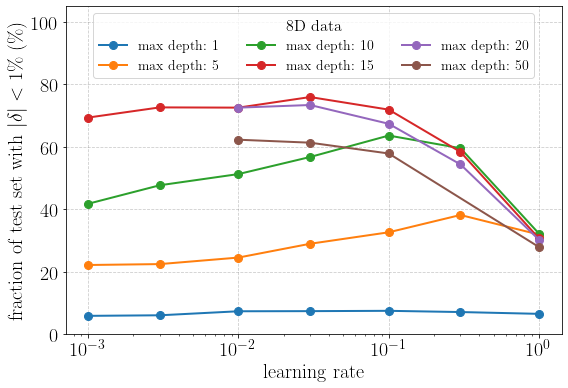

In [41]:
df_data = df_data[df_data['lr'] >= 0.001]
plt.figure(figsize=(8,5.5))
linewidth = 2
markersize = 8
plt.plot(df_data[df_data['depth'] == 1]['lr'], df_data[df_data['depth'] == 1]['delta1'], linewidth=linewidth, label='max depth: 1', marker= 'o', markersize=markersize)
plt.plot(df_data[df_data['depth'] == 5]['lr'], df_data[df_data['depth'] == 5]['delta1'], linewidth=linewidth, label='max depth: 5', marker= 'o', markersize=markersize)
plt.plot(df_data[df_data['depth'] == 10]['lr'], df_data[df_data['depth'] == 10]['delta1'], linewidth=linewidth, label='max depth: 10', marker= 'o', markersize=markersize)
plt.plot(df_data[df_data['depth'] == 15]['lr'], df_data[df_data['depth'] == 15]['delta1'], linewidth=linewidth, label='max depth: 15', marker= 'o', markersize=markersize)
plt.plot(df_data[df_data['depth'] == 20]['lr'], df_data[df_data['depth'] == 20]['delta1'], linewidth=linewidth, label='max depth: 20', marker= 'o', markersize=markersize)
plt.plot(df_data[df_data['depth'] == 50]['lr'], df_data[df_data['depth'] == 50]['delta1'], linewidth=linewidth, label='max depth: 50', marker= 'o', markersize=markersize)

legend = plt.legend(fontsize=14, loc='upper center', ncol=3, title='8D data')
plt.setp(legend.get_title(),fontsize=16)
plt.xlabel(r'learning rate', fontsize=20)
plt.ylabel(r'fraction of test set with $|\delta| < 1\% \;(\%)$', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xscale('log')
# plt.yscale('log')
plt.ylim(0, 105)
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.tight_layout()
plt.savefig('../plots/lr-depth.pdf', dpi=300)
plt.show()

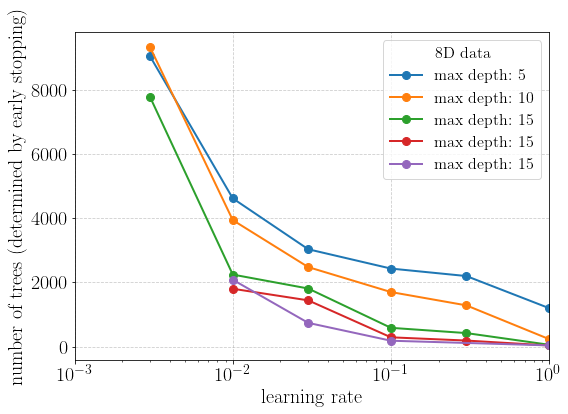

In [42]:
df_data_1 = df_data[df_data['lr'] >= 0.003]
plt.figure(figsize=(8,5.5))
linewidth = 2
markersize = 8
plt.plot(df_data_1[df_data_1['depth'] == 5]['lr'], df_data_1[df_data_1['depth'] == 5]['num_trees'], linewidth=linewidth, label='max depth: 5', marker= 'o', markersize=markersize)
plt.plot(df_data_1[df_data_1['depth'] == 10]['lr'], df_data_1[df_data_1['depth'] == 10]['num_trees'], linewidth=linewidth, label='max depth: 10', marker= 'o', markersize=markersize)
plt.plot(df_data_1[df_data_1['depth'] == 15]['lr'], df_data_1[df_data_1['depth'] == 15]['num_trees'], linewidth=linewidth, label='max depth: 15', marker= 'o', markersize=markersize)
plt.plot(df_data_1[df_data_1['depth'] == 20]['lr'], df_data_1[df_data_1['depth'] == 20]['num_trees'], linewidth=linewidth, label='max depth: 20', marker= 'o', markersize=markersize)
plt.plot(df_data_1[df_data_1['depth'] == 50]['lr'], df_data_1[df_data_1['depth'] == 50]['num_trees'], linewidth=linewidth, label='max depth: 50', marker= 'o', markersize=markersize)
legend = plt.legend(fontsize=16, loc='upper right', ncol=1, title='8D data')
plt.setp(legend.get_title(),fontsize=16)
plt.xlabel(r'learning rate', fontsize=20)
plt.ylabel(r'number of trees (determined by early stopping)', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xscale('log')
# plt.yscale('log')
plt.xlim(0.001, 1)
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.tight_layout()
plt.savefig('../plots/trees-depth.pdf', dpi=300)
plt.show()

In [40]:
lr_files = sorted(glob.glob('../src/bdt/lr-dims/*normal*'))

In [41]:
lr_data = {}

for file in lr_files:
    testModel(file, df_dict, data=lr_data)

In [42]:
errorTails = getErrorTail(1, lr_data)

In [43]:
df_data_lr = pd.DataFrame(columns=['dim', 'depth', 'num_trees', 'delta1', 'absdelta', 'lr'])
for key in errorTails.keys():
    df_data_lr.loc[len(df_data_lr)] = [errorTails[key]['dim'], errorTails[key]['depth'], errorTails[key]['num_trees'], 
                                 errorTails[key]['error < 1%'], errorTails[key]['$\mu_{error}$ (%)'], 
                                 errorTails[key]['lr']]

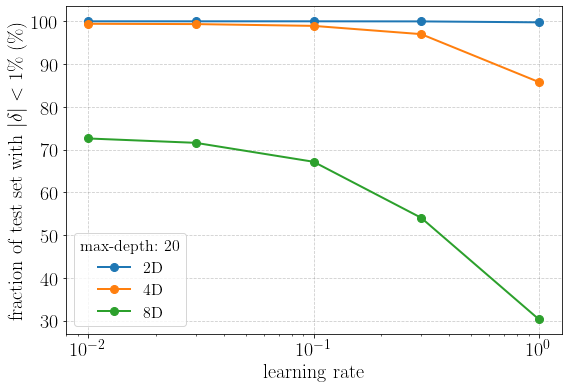

In [45]:
plt.figure(figsize=(8,5.5))
plt.plot(df_data_lr[df_data_lr['dim'] == 2]['lr'], df_data_lr[df_data_lr['dim'] == 2]['delta1'], marker='o', linewidth=2, markersize=8, label=r'2D')
plt.plot(df_data_lr[df_data_lr['dim'] == 4]['lr'], df_data_lr[df_data_lr['dim'] == 4]['delta1'], marker='o', linewidth=2, markersize=8, label=r'4D')
plt.plot(df_data_lr[df_data_lr['dim'] == 8]['lr'], df_data_lr[df_data_lr['dim'] == 8]['delta1'], marker='o', linewidth=2, markersize=8, label=r'8D')
legend = plt.legend(fontsize=16, title='max-depth: 20\n learning rate: 0.03', loc='lower right')
legend = plt.legend(fontsize=16, title='max-depth: 20')
plt.setp(legend.get_title(),fontsize=16)
plt.xlabel(r'learning rate', fontsize=20)
plt.ylabel(r'fraction of test set with $|\delta| < 1\% \;(\%)$', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xscale('log')
# plt.xticks(df_2D[0].values, fontsize=20)
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.tight_layout()
plt.savefig('../plots/lr-BDT.pdf', dpi=300)
plt.show()